In [ ]:
!pip install praw

In [ ]:
import praw

reddit = praw.Reddit(client_id='FXkDFnmCuSCeLGy1FZylTg',
                     client_secret='uE0JH_54DgSwi23ecjSPCio0xCeQRQ',
                     user_agent='script-analytics (by u/thataccountalp)')

subreddit = reddit.subreddit('India')

search_query = 'women safety'
posts = subreddit.search(search_query, limit=100)

post_list = []
for post in posts:
    post_list.append([post.title, post.selftext, post.score, post.created_utc])


for post in post_list:
  print(f"Title: {post[0]}\nContent: {post[1]}\nScore: {post[2]}\nDate: {post[3]}\n")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Title: It's about time we completely acknowledge that india is one of the worst countries in the world when it comes to women safety. 
Content: 

It's ironic how many times I heard men in Delhi say the city is safe, yet every girl I know who's visited, and many who've lived there, talk about how unsafe they felt. This isn't just about Delhi; every place in India is unsafe for women. Whenever something happens, men often try to sweep the problem under the rug. I've seen this happen: they'll point out that other countries have higher rape rates, say she shouldn't have been out so late, bring up false rape charges (which are a drop in the ocean), or derail the conversation by saying "men get raped too." Every time men see a problem, they want to ignore it.

How many times have you seen men making misogynistic comments and just turned a blind eye? Do you think rapists wake up one day and suddenly decide to rape? No! All the misogynistic things men say contribute to this.  Those who think o

In [ ]:
import pandas as pd

df = pd.DataFrame(post_list, columns=['Title', 'Content', 'Score', 'Date'])

df.head()

df.to_csv('womens_safety_reddit_posts.csv', index=False)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)

    text = text.lower()

    text_tokens = text.split()
    filtered_text = [word for word in text_tokens if word not in stop_words]
    return " ".join(filtered_text)

df['Cleaned_Content'] = df['Content'].apply(clean_text)

df[['Content', 'Cleaned_Content']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Content,Cleaned_Content
0,\n\nIt's ironic how many times I heard men in ...,ironic many times heard men delhi say city saf...
1,I see many posts asking questions about things...,see many posts asking questions things thought...
2,Scrap 2036 Olympic hosting ideas and focus mor...,scrap olympic hosting ideas focus improve safe...
3,,
4,posting a story on instagram won't make a diff...,posting story instagram wont make difference n...


In [ ]:
!pip install nltk

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

df['Cleaned_Content'] = df['Content'].apply(clean_text)

df['Sentiment_Scores'] = df['Cleaned_Content'].apply(lambda x: sid.polarity_scores(x))

df['Sentiment'] = df['Sentiment_Scores'].apply(lambda x: 'positive' if x['compound'] > 0.05
                                               else ('negative' if x['compound'] < -0.05 else 'neutral'))


df[['Cleaned_Content', 'Sentiment']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Cleaned_Content,Sentiment
0,ironic many times heard men delhi say city saf...,negative
1,see many posts asking questions things thought...,positive
2,scrap olympic hosting ideas focus improve safe...,positive
3,,neutral
4,posting story instagram wont make difference n...,negative


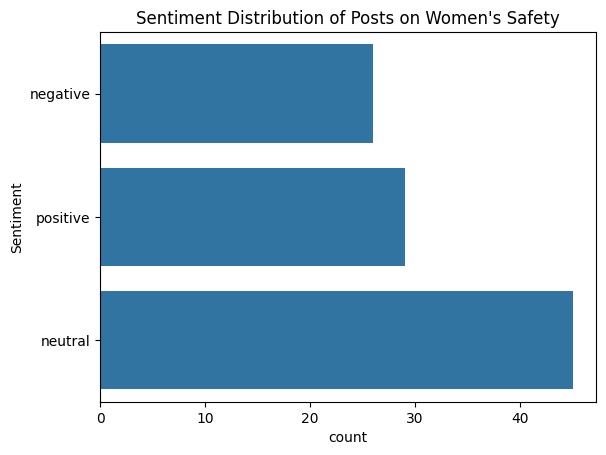

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df['Sentiment'])
plt.title('Sentiment Distribution of Posts on Women\'s Safety')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['Cleaned_Content'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

def display_topics(model, feature_names, no_top_words):
  for topic_idx, topic in enumerate(model.components_):
    print(f"Topics {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topics 1:
women police rape men house yearold like cases accused things
Topics 2:
sex like dont time know porn partner youll xb need
Topics 3:
women want girls rape men safety like act consequences way
Topics 4:
dont women india people like know edit rape make im
Topics 5:
women information india safety data cameras cctv family help home


In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, doc_term_matrix, vectorizer, mds='tsne')

pyLDAvis.display(panel)

In [ ]:
sentiment_group = df.groupby('Sentiment')['Cleaned_Content'].count()

print(sentiment_group)

Sentiment
negative    26
neutral     45
positive    29
Name: Cleaned_Content, dtype: int64


In [ ]:
df['Dominant_Topic'] = lda.transform(doc_term_matrix).argmax(axis=1)

sentiment_topic_group = df.groupby(['Dominant_Topic', 'Sentiment'])['Cleaned_Content'].count().unstack()

print(sentiment_topic_group)

Sentiment       negative  neutral  positive
Dominant_Topic                             
0                    7.0     44.0       3.0
1                    NaN      NaN       2.0
2                    7.0      NaN       3.0
3                    4.0      NaN      14.0
4                    8.0      1.0       7.0


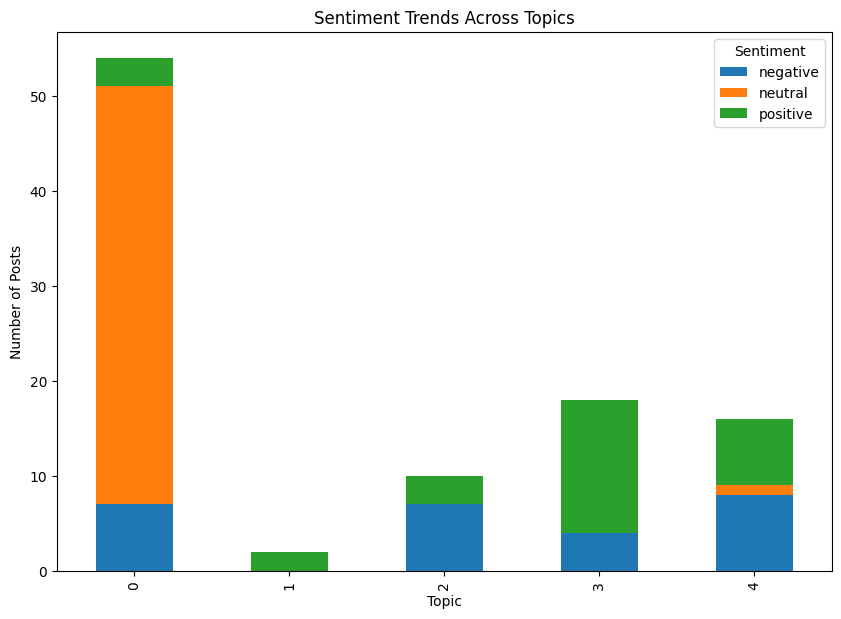

In [ ]:
import matplotlib.pyplot as plt

sentiment_topic_group.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Sentiment Trends Across Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Posts')
plt.show()